In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate, KFold


In [6]:
import scanpy as sc
# import scvelo as scv

# data = sc.read('/home/evanlee/PBMC_Hao/Hao_PBMC_level1_rep_cells.h5ad')
data = sc.read('/Users/evanli/Documents/Research_datasets/PBMC_Hao/Hao_PBMC.h5ad')
# data = sc.read_h5ad('/home/jovyan/work/Research_datasets/Hao_PBMC.h5ad')
# data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Hao_PBMC.h5ad")
data.shape

(161764, 20568)

In [6]:
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [7]:
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


## Read features

In [15]:
# Level 2 ADlasso features by loss convergence (level2_loss_converge/loss_feature_selection)
# selected at optimal lambda tuned at Level2_pvl0_ttsplit
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_loss_converge\loss_feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [16]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,3902,11
B_intermediate,9,6
B_memory,21,12
B_naive,16,11
CD14_Mono,15,7
CD16_Mono,41,20
CD4_CTL,69,17
CD4_Naive,70,34
CD4_Proliferating,2324,54
CD4_TCM,54,29


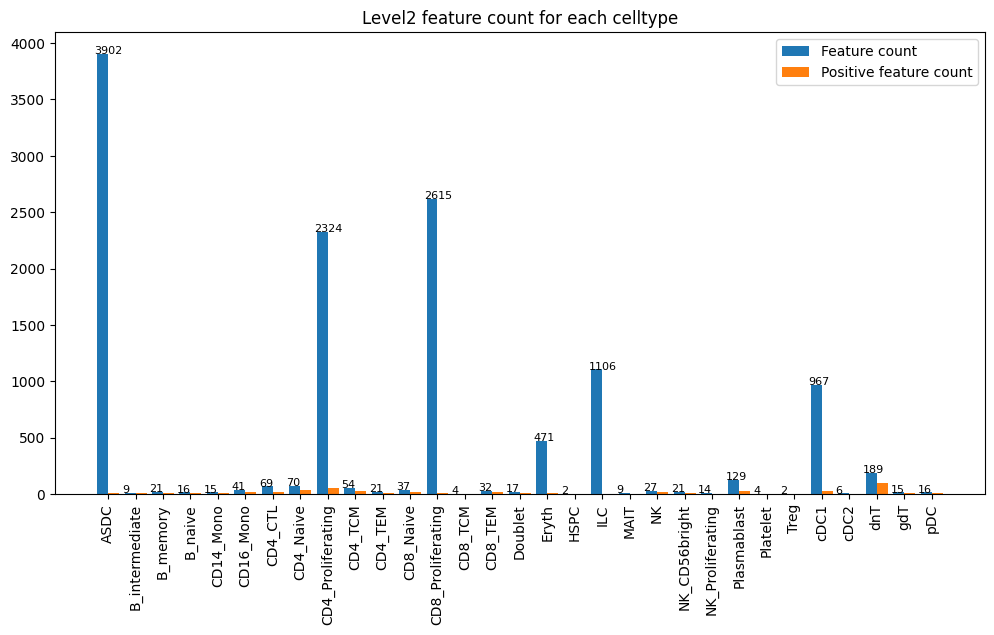

In [13]:
# plot barplot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(count_df.index))
bar_width = 0.4

ax.bar(x - bar_width/2, count_df['Feature_count'], bar_width, label='Feature count')
ax.bar(x + bar_width/2, count_df['Positive_feature_count'], bar_width, label='Positive feature count')

# Add the values to each bar
for i, v in enumerate(count_df['Feature_count']):
    plt.text(i-0.5, v, str(v), fontsize=8)
# for i, v in enumerate(count_df['Positive_feature_count']):
#     plt.text(i, v, str(v), fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(count_df.index)
plt.xticks(rotation=90)
plt.title('Level2 feature count for each celltype')
ax.legend()
# plt.savefig('L2_feature_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Build classifiers (K-fold CV)

In [15]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc'
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_f1, mean_auc]

    return clf, mean_metrics

In [ ]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_loss_converge\classifier_all")

all_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    all_metrics = pd.concat([all_metrics, pd.DataFrame([metrics], columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])], axis=0)
    
    # output LR model as pickle
    filename = f'LR_{celltype}_loss_l2.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


## Read saved .pkl

## Plot classifier K-fold CV metrics

In [10]:
import scanpy as sc
data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\Hao_PBMC.h5ad")
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print(types)


['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [4]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_loss_converge\classifier_all_2")

In [11]:
all_metrics = pd.read_csv('L2_loss_classifier_metrics.csv', index_col=0)
all_metrics.index = types
all_metrics.head()

,Accuracy,Precision,F1-score,ROC-AUC
ASDC,0.999790,1.000000,0.700236,0.999986
B_intermediate,0.987970,0.687691,0.481510,0.988160
B_memory,0.994164,0.876905,0.852314,0.998053
B_naive,0.995642,0.950463,0.954530,0.999401
CD14_Mono,0.987216,0.967987,0.975982,0.998321


In [12]:
all_metrics.shape

(31, 4)

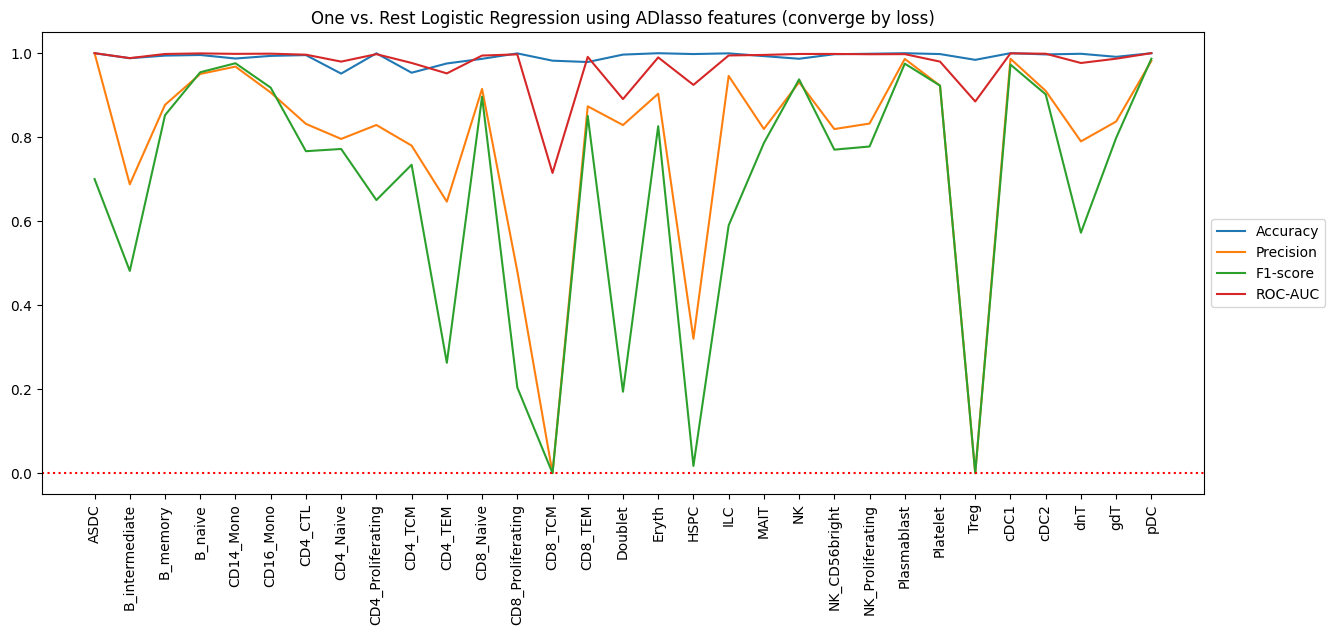

In [14]:
# line graph

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(15, 6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)

# Add horizontal red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')

plt.show()

#TODO: compare the celltype metrics with feature count

## Evaluate by DEGn

In [20]:
# Read DEG table
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Classifier_evaluation\DEG_table")

celltype = 'ASDC'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']  # 3902
DEGn = DEG_table['names'][:n_features].tolist()

In [18]:
len(DEGn)

2000

In [19]:
n_features

3902

In [21]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)  # average='macro'
    print("Precision: {:.2f}%".format(precision * 100))
    f1 = f1_score(y_test, y_pred)
    print("F1: {:.2f}%".format(f1 * 100))
    # AUC-ROC
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print('ROC-AUC:', roc_auc)

    # model metrics
    metrics = [accuracy, precision, f1, roc_auc]

    return clf, metrics

In [22]:
count_df.head()

,Feature_count,Positive_feature_count
ASDC,3902,11
B_intermediate,9,6
B_memory,21,12
B_naive,16,11
CD14_Mono,15,7


In [23]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Classifier_evaluation\DEG_table")

all_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'F1-score', 'ROC-AUC'])

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(data, DEGn, celltype)
    all_metrics.loc[celltype] = celltype_metrics

Constructing classifier for: ASDC
n: 3902
(161764, 2000)
Accuracy: 99.99%
Precision: 100.00%
F1: 92.86%
ROC-AUC: 1.0
Constructing classifier for: B_intermediate
n: 9
(161764, 9)
Accuracy: 98.65%
Precision: 63.74%
F1: 34.73%
ROC-AUC: 0.9824985042643157
Constructing classifier for: B_memory
n: 21
(161764, 21)
Accuracy: 98.75%
Precision: 74.52%
F1: 65.70%
ROC-AUC: 0.9908888531613493
Constructing classifier for: B_naive
n: 16
(161764, 16)
Accuracy: 99.37%
Precision: 92.62%
F1: 93.45%
ROC-AUC: 0.9988987808387193
Constructing classifier for: CD14_Mono
n: 15
(161764, 15)
Accuracy: 98.85%
Precision: 97.61%
F1: 97.83%
ROC-AUC: 0.9986802107897474
Constructing classifier for: CD16_Mono
n: 41
(161764, 41)
Accuracy: 99.35%
Precision: 92.23%
F1: 91.64%
ROC-AUC: 0.9985345512739864
Constructing classifier for: CD4_CTL
n: 69
(161764, 69)
Accuracy: 99.17%
Precision: 69.35%
F1: 50.55%
ROC-AUC: 0.9877335679675334
Constructing classifier for: CD4_Naive
n: 70
(161764, 70)
Accuracy: 94.37%
Precision: 77.03%


In [24]:
all_metrics

,Accuracy,Precision,F1-score,ROC-AUC
ASDC,0.999938,1.000000,0.928571,1.000000
B_intermediate,0.986524,0.637363,0.347305,0.982499
B_memory,0.987544,0.745174,0.657021,0.990889
B_naive,0.993695,0.926209,0.934531,0.998899
CD14_Mono,0.988533,0.976099,0.978323,0.998680
CD16_Mono,0.993509,0.922276,0.916401,0.998535
CD4_CTL,0.991655,0.693467,0.505495,0.987734
CD4_Naive,0.943746,0.770323,0.724075,0.970241
CD4_Proliferating,0.999784,0.826087,0.844444,0.999629
CD4_TCM,0.943004,0.742308,0.653253,0.965027


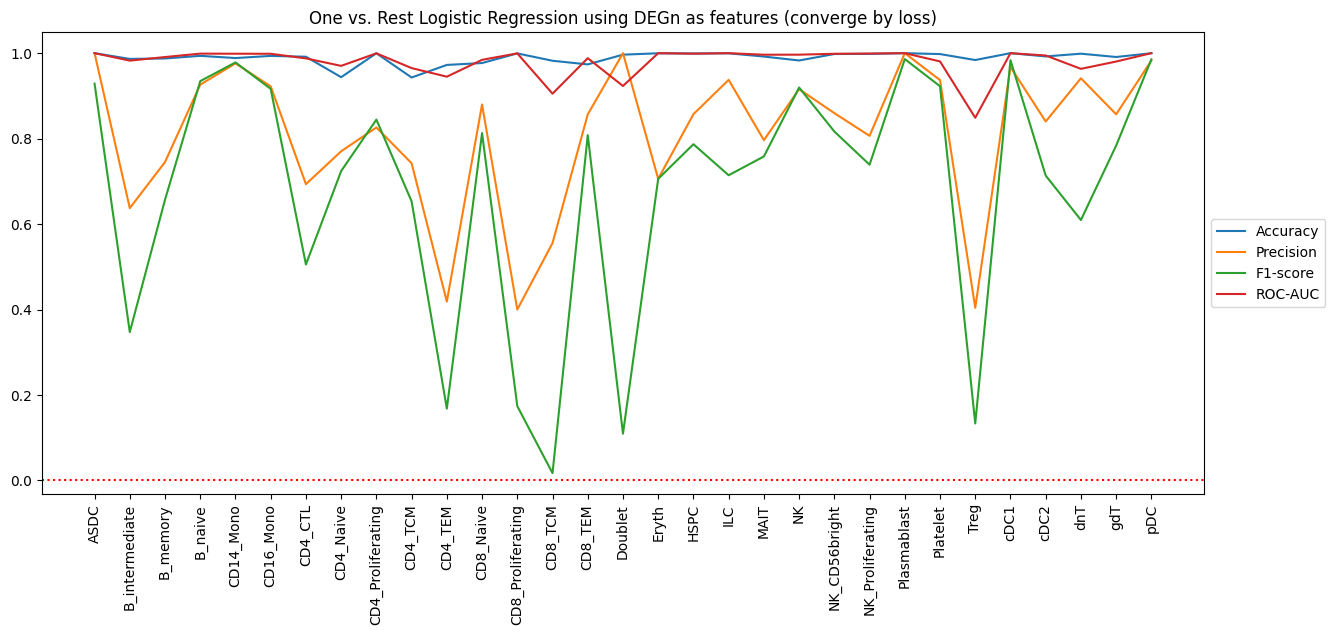

In [25]:
# line graph

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(15, 6), title='One vs. Rest Logistic Regression using DEGn as features (converge by loss)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)

# Add horizontal red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')

plt.show()

#TODO: compare the celltype metrics with feature count

In [28]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao\Level2_loss_converge\classifier_all_2")
all_metrics.to_csv('L2_loss_DEGn_metrics.csv')

## Combine plots: ADlasso features vs. DEG

In [9]:
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_loss_converge/classifier_all_2')
metrics_adlasso = pd.read_csv('L2_loss_classifier_metrics.csv', index_col=0)
metrics_adlasso.index = types
metrics_DEGn = pd.read_csv('L2_loss_DEGn_metrics.csv', index_col=0)
metrics_DEGn.index = types

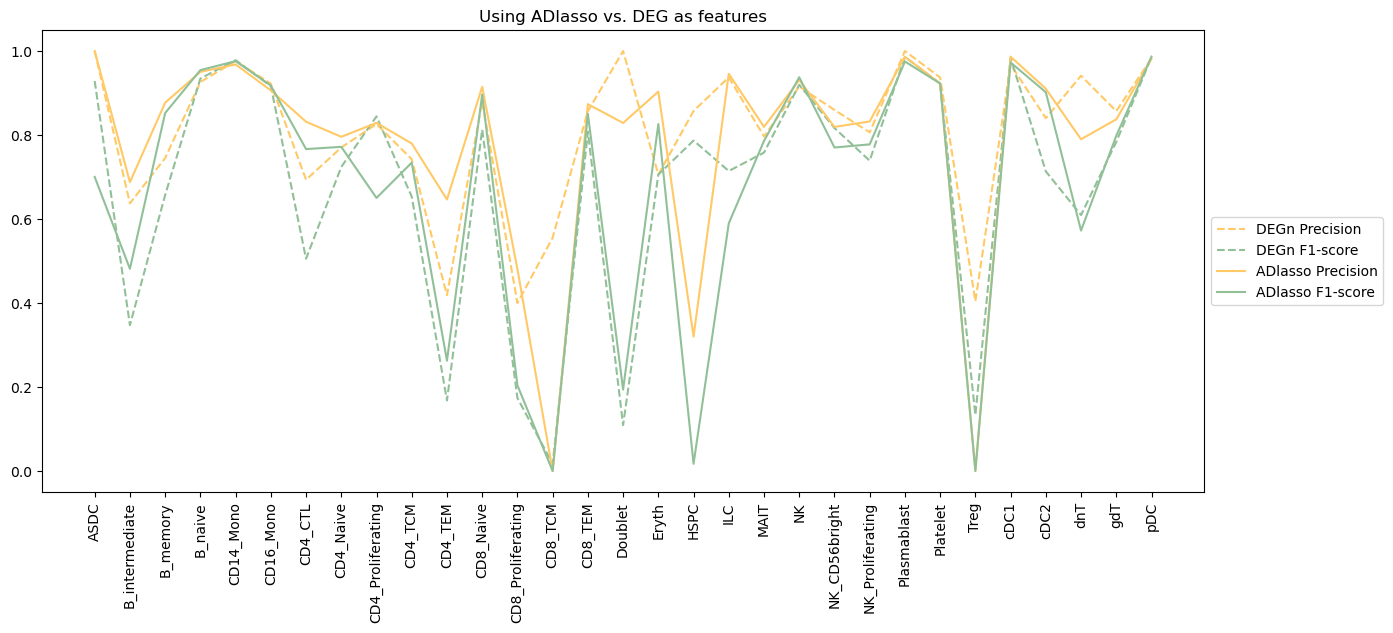

In [12]:
# Overlap two plots
# ADlasso metrics (line) vs. DEG metrics (dotted line)
ax = metrics_DEGn[['Precision', 'F1-score']].plot.line(rot=0, figsize=(15, 6), title='Using ADlasso vs. DEG as features', color=['#ffc966', '#91c098'], linestyle='dashed')
metrics_adlasso[['Precision', 'F1-score']].plot.line(ax=ax, rot=0, color=['#ffc966', '#91c098'])

ax.legend(['DEGn Precision','DEGn F1-score','ADlasso Precision','ADlasso F1-score'], loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(metrics_adlasso.index)), metrics_adlasso.index, rotation=90)

plt.show()